In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import tensorflow as tf
import keras
import sys
from tensorflow.keras.layers import Layer, Dense, LSTM, GRU, Dropout, Input, Concatenate, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import keras_tuner as kt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from category_encoders import CatBoostEncoder
from sklearn.model_selection import train_test_split

# For reproducibility
tf.random.set_seed(42)
np.random.seed(42)
plt.rcParams['text.usetex'] = True

# Setting directory
os.chdir('/Users/manotas/Documents/GitHub-Repos/CFForecast_Energy_OptionValuation')

In [2]:
data = pd.read_csv('data/processed/TopRevenueMNC.csv')

In [3]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print()
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.14.0
Keras Version: 2.14.0

Python 3.9.13 (main, Oct 20 2023, 23:53:00) 
[Clang 15.0.0 (clang-1500.0.40.1)]

GPU is AVAILABLE


In [28]:
# Melt the dataframe to long format
value_vars = [col for col in data.columns if any(year in col for year in ['2023', '2022', '2021', '2020', '2019'])]
id_vars = [col for col in data.columns if col not in value_vars]

# Create a new DataFrame by melting
melted_data = pd.melt(data, id_vars=id_vars, value_vars=value_vars, 
                      var_name='metric_year', value_name='value')

# Extract metric and year from 'metric_year'
melted_data['metric'] = melted_data['metric_year'].apply(lambda x: '_'.join(x.split('_')[:-1]))
melted_data['year'] = melted_data['metric_year'].apply(lambda x: x.split('_')[-1]).astype(int)

# Pivot the table to have years as rows
processed_data = melted_data.pivot_table(index=id_vars + ['year'], columns='metric', values='value').reset_index()

# Initialize the scaler and encoder
scaler = StandardScaler()

# Scale the numerical columns
numerical_columns = ['operating_revenue', 'net_income', 'total_assets', 
                     'profit_margin', 'solvency_ratio', 'cogs', 'ebitda', 'cash', 'cash_flow']
processed_data[numerical_columns] = scaler.fit_transform(processed_data[numerical_columns])

# Encode categorical columns
processed_data = processed_data.drop(columns=['quoted','country','industry'])

# Save the scaler for later use
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

processed_data.head(10)

metric,company,year,cash,cash_flow,cogs,ebitda,net_income,operating_revenue,profit_margin,solvency_ratio,total_assets
0,A2A S.P.A.,2019,-0.186611,-0.113742,0.050296,-0.107829,-0.050281,-0.083231,-0.053813,-0.212344,-0.139042
1,A2A S.P.A.,2020,0.041915,-0.092808,0.051733,-0.096022,-0.047253,-0.078214,-0.120052,-0.227164,-0.092646
2,A2A S.P.A.,2021,-0.003531,-0.057679,-0.123806,-0.077898,-0.008334,0.043173,-0.224178,-0.612303,-0.007939
3,A2A S.P.A.,2022,0.500703,-0.081176,-0.571526,-0.079468,-0.053195,0.346078,-0.335542,-0.730119,0.029664
4,A2A S.P.A.,2023,0.211043,-0.010680,-0.221091,-0.005285,0.040992,0.127237,-0.173080,-0.547266,-0.002035
5,AB IGNITIS GROUP,2019,-0.289456,-0.251609,0.242775,-0.254855,-0.167304,-0.265420,-0.168918,0.108034,-0.271846
6,AB IGNITIS GROUP,2020,-0.089401,-0.225434,0.240854,-0.234367,-0.121560,-0.258577,0.431160,0.268695,-0.252706
7,AB IGNITIS GROUP,2021,-0.180229,-0.227265,0.213895,-0.238076,-0.132620,-0.241792,0.005308,0.160182,-0.252650
8,AB IGNITIS GROUP,2022,-0.110027,-0.205151,0.125463,-0.212509,-0.089168,-0.175683,-0.068472,0.035192,-0.239964
9,AB IGNITIS GROUP,2023,-0.265597,-0.196564,0.199222,-0.214765,-0.076354,-0.224180,0.305136,0.146977,-0.237257


In [5]:
# Assuming `processed_data` is the DataFrame
companies = processed_data['company'].unique()
X_all, y_all = [], []

for company in companies:
    company_data = processed_data[processed_data['company'] == company].sort_values(by='year')
    X_company, y_company = [], []
    for i in range(len(company_data) - 1):
        X_company.append(company_data.iloc[i, 3:].values)  # All columns except 'company', 'quoted', 'country', 'industry', 'year'
        y_company.append(company_data.iloc[i + 1]['cash_flow'])  # Target is cash_flow at t
    
    X_all.append(np.array(X_company))
    y_all.append(np.array(y_company))

# Convert to numpy arrays and change the dtype to float32
X_all = np.array(X_all, dtype=np.float32)
y_all = np.array(y_all, dtype=np.float32)

# Verify the shapes
print(f'Shape of X_all: {X_all.shape}')
print(f'Shape of y_all: {y_all.shape}')

Shape of X_all: (118, 4, 8)
Shape of y_all: (118, 4)


In [6]:
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size=1, **kwargs):
        self.kernel_size = kernel_size
        super(Time2Vec, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='W', shape=(input_shape[-1], self.kernel_size),
                                 initializer='uniform', trainable=True)
        self.B = self.add_weight(name='B', shape=(1, self.kernel_size),
                                 initializer='uniform', trainable=True)
        self.w = self.add_weight(name='w', shape=(input_shape[-1],),
                                 initializer='uniform', trainable=True)
        self.b = self.add_weight(name='b', shape=(input_shape[-1],),
                                 initializer='uniform', trainable=True)
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs):
        bias = self.w * inputs + self.b
        dp = tf.matmul(inputs, self.W) + self.B
        wgts = tf.math.sin(dp)
        return tf.concat([wgts, bias], -1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2] * 2

def build_model(hp):
    inputs = Input(shape=(X_all.shape[1], X_all.shape[2]))
    time2vec = Time2Vec(kernel_size=hp.Int('t2v_kernel_size', min_value=1, max_value=5))(inputs)
    
    x = time2vec
    
    for i in range(hp.Int('num_layers', 1, 3)):
        if hp.Choice('rnn_type', ['LSTM', 'GRU']) == 'LSTM':
            x = Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
                                   return_sequences=True))(x)
        else:
            x = Bidirectional(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32), 
                                  return_sequences=True))(x)
        if hp.Boolean('dropout'):
            x = Dropout(rate=0.2)(x)

    # Adding Attention Mechanism
    attention = Attention()([x, x])
    
    # Reduce to single output
    x = Dense(1)(attention)
    
    model = Model(inputs, x)
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mse', 
                  metrics=['mae'])
    return model

In [7]:
tuner = kt.BayesianOptimization(build_model,
                                objective='val_mae',
                                max_trials=100,
                                directory='models/bayesian_optimization',
                                project_name='time2vec_rnn')

# Splitting the data into train and test sets
split_idx = int(0.8 * len(X_all))
X_train_np, X_test_np = X_all[:split_idx], X_all[split_idx:]
y_train_np, y_test_np = y_all[:split_idx], y_all[split_idx:]

tuner.search(X_train_np, y_train_np, epochs=100, validation_data=(X_test_np, y_test_np))

Reloading Tuner from models/bayesian_optimization/time2vec_rnn/tuner0.json


In [8]:
# Retrieving the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Verifying the best hyperparameters
tuner.get_best_hyperparameters()[0].values

2024-07-03 15:20:36.823720: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-07-03 15:20:36.823769: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-03 15:20:36.823778: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-03 15:20:36.824060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-03 15:20:36.824385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


{'t2v_kernel_size': 2,
 'num_layers': 2,
 'rnn_type': 'LSTM',
 'units': 96,
 'dropout': False,
 'learning_rate': 0.001}

In [9]:
# Evaluate the best model
best_model.evaluate(X_test_np, y_test_np)

2024-07-03 15:20:38.173758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-07-03 15:20:38.232357: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 1s 1s/step - loss: 0.0498 - mae: 0.0957


[0.049753278493881226, 0.09569685906171799]

In [10]:
# Storing the best model
best_model.save('models/time2vec_rnn_best_model')

INFO:tensorflow:Assets written to: models/time2vec_rnn_best_model/assets


INFO:tensorflow:Assets written to: models/time2vec_rnn_best_model/assets


In [11]:
# Loading the best model
best_model = load_model('models/time2vec_rnn_best_model')

In [12]:
y_pred_train = np.squeeze(best_model.predict(X_train_np), axis=-1)
y_pred_test = np.squeeze(best_model.predict(X_test_np), axis=-1)

2024-07-03 15:20:47.651160: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1/1 [==============================] - 0s 73ms/step


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_actual, predictions):
    '''
    A function that calculates and prints the RMSE, MAE, sMAPE and R2 score of a given actual and predicted series.
    A caveat of sMAPE, we measure it as outlined by Makridakis and Hibon (2000). Further information can be found in:
    https://robjhyndman.com/hyndsight/smape/. As well as both sources defined in the references folder.
    '''
    # Calculate Mean Squared Error and Root Mean Squared Error
    mse = mean_squared_error(y_actual, predictions)
    rmse = np.sqrt(mse)
    
    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_actual, predictions)
    
    # Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    smape = np.mean(2.0 * np.abs(y_actual - predictions) / ((np.abs(y_actual) + np.abs(predictions)) + 1e-10)) * 100
    
    # Calculate R-squared
    r2 = r2_score(y_actual, predictions)

    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'sMAPE(0-200): {smape}%')
    print(f'R-squared: {r2}')

In [14]:
print('Best RNN model - Train metrics:')
calculate_metrics(y_train_np, y_pred_train)
print('\n Best RNN model - Test metrics:')
calculate_metrics(y_test_np, y_pred_test)

Best RNN model - Train metrics:
RMSE: 0.22897104918956757
MAE: 0.06671774387359619
sMAPE(0-200): 18.333913385868073%
R-squared: 0.8091707007963322

 Best RNN model - Test metrics:
RMSE: 0.223054438829422
MAE: 0.09569685161113739
sMAPE(0-200): 37.482818961143494%
R-squared: 0.9872139223029276


Epoch 1/100
3/3 [==============================] - 0s 43ms/step - loss: 0.0067 - mae: 0.0337 - val_loss: 1.2063 - val_mae: 0.3341
Epoch 2/100
3/3 [==============================] - 0s 34ms/step - loss: 0.0066 - mae: 0.0330 - val_loss: 1.2154 - val_mae: 0.3348
Epoch 3/100
3/3 [==============================] - 0s 35ms/step - loss: 0.0066 - mae: 0.0330 - val_loss: 1.2061 - val_mae: 0.3348
Epoch 4/100
3/3 [==============================] - 0s 35ms/step - loss: 0.0066 - mae: 0.0331 - val_loss: 1.1935 - val_mae: 0.3313
Epoch 5/100
3/3 [==============================] - 0s 36ms/step - loss: 0.0066 - mae: 0.0335 - val_loss: 1.1963 - val_mae: 0.3320
Epoch 6/100
3/3 [==============================] - 0s 36ms/step - loss: 0.0066 - mae: 0.0326 - val_loss: 1.2001 - val_mae: 0.3320
Epoch 7/100
3/3 [==============================] - 0s 35ms/step - loss: 0.0065 - mae: 0.0326 - val_loss: 1.1761 - val_mae: 0.3290
Epoch 8/100
3/3 [==============================] - 0s 35ms/step - loss: 0.0065 - mae: 0.03

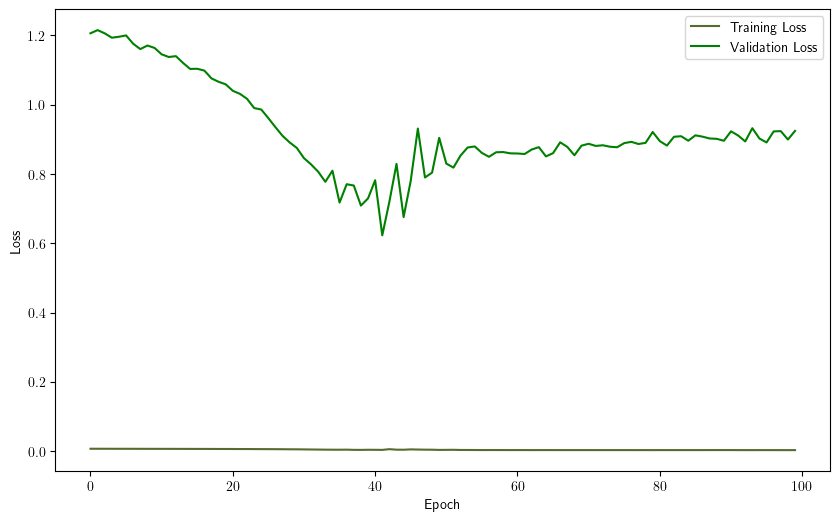

In [18]:
# Training the best model
history = best_model.fit(X_all, y_all, epochs=100, validation_split=0.2)

# Plotting the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='darkolivegreen')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('reports/images/epoch_history_loss.pdf', dpi=320)
plt.show()

In [16]:
from keras.utils import plot_model
from tensorflow.keras.utils import plot_model

# Visualize the RNN model architecture
plot_model(best_model, to_file='reports/images/model_architecture.pdf', show_shapes=True, show_layer_names=True, dpi=320)

In [32]:
if not os.path.exists('data/interim'):
    os.makedirs('data/interim')

# Combine the train and test predictions
y_pred_combined = np.concatenate([y_pred_train, y_pred_test], axis=0)

# Save the RNN predictions to a pickle file
with open('data/interim/rnn_predictions.pkl', 'wb') as f:
    pickle.dump(y_pred_combined, f)